# Set up
This section should be interacted with. Use `data_path` to designate the folder where the OpenBARR data is. This folder needs to be formatted beforehand - take a look at the **README** or see `/sample_data/original_data` for an example. Change `output_path` to a folder where you want the graphs and the data used to make them.

Here, you will also specify the experimental conditions in `conditions` and days in `days`. This will help the program navigate the files and batch process.


In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# import packages we need for analysis and graphing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# specify where the data is
data_path = '/content/drive/MyDrive/0 Revamp/sample_data/original_data'
output_path = '/content/drive/MyDrive/0 Revamp/sample_data/output'

# specify experimental conditions
conditions = ['3EtOH', '25EtOH', '50EtOH', '75EtOH']
days = ['D1', 'D2', 'D3']

# specify some aesthetic stuff
colors = [
    ['#4188C5', '#326EA3', '#26547C'],  # for condition 0, 3EtOH, days 1, 2, and 3
    ['#F47C98', '#F16284', '#EF476F'],  # for condition 1, 25Etoh, days 1, 2, and 3
    ['#FFDE92', '#FFD87C', '#FFD166'],  # ...
    ['#35FAC5', '#0CF9BA', '#06D6A0']
  ]

# in case you have data preprocessed already
tracking_df = pd.read_csv(os.path.join(output_path, 'tracking_df.csv'))
bouts_df = pd.read_csv(os.path.join(output_path, 'bouts_df.csv'))

Mounted at /content/drive


# Preprocess the data
We read in and format the OpenBARR data to be more understandable and remove the first second of data in case of initial mistracking.

In [5]:
def read_raw(file_path):
  """Read an OpenBARR file.

  Reads a tab-delimited OpenBARR file and specifies the column names.

  Parameters
  ----------
  file_path : str
    The path to the OpenBARR file.

  Returns
  -------
  pandas.DataFrame
    A DataFrame containing the data from the OpenBARR file.
  """
  return pd.read_csv(file_path, sep='\t', header=None,
                     names=['time', 'x', 'y', 'in', 'entry', 'exit'])

def adjust_y(df):
  """Adjust the y-coordinates of an OpenBARR dataframe.

  Adjusts the y-coordinates of an OpenBARR dataframe relative to the border of
  ROSA and RONSA. Where y >= 0 indicates how far animal is in ROSA while y < 0
  indicate how far animal is in RONSA. This adjustment makes the data more
  intuitive and easier to analyze.

  Parameters
  ----------
  df : pandas.DataFrame
    A DataFrame containing the data from the OpenBARR file.

  Notes
  -----
  This works under the assumption, in short, that the OpenBARR is set up in the
  exact same way. Common problems could be flipped ROSA/RONSA causing RONSA to
  be >= 0 and ROSA <0 and camera height differences could change the arbitrary
  coordinates, affecting the adjustment for a fly never entering ROSA.
  """
  border = df[df['entry'] == 1]['y']  # get y-coords when fly initially enters ROSA
  if len(border) > 0:  # if fly was ever in ROSA
    df.loc[:, 'y'] = max(border) - df['y']  # the adjustment
  else:  # if the fly never entered ROSA,
    df.loc[:, 'y'] = 235 - df['y']  # use upper-bound estimate - see notes

def preprocess(file_path):
  """Preprocess an OpenBARR file.

  Reads an OpenBARR file, removes the first second of data, and adjusts the
  y-coordinates relative to the border of ROSA and RONSA.

  Parameters
  ----------
  file_path : str
    The path to the OpenBARR file.

  Returns
  -------
  pandas.DataFrame
    A DataFrame containing the preprocessed data from the OpenBARR file.
  """
  df = read_raw(file_path)
  df = df[df['time'] >= 1]
  adjust_y(df)
  return df.reset_index(drop=True)

def get_bouts(df):
  """Retrieve bout data for an OpenBARR dataframe.

  Extracts bout data to make some analyses easier. A bout is defined as a
  continuous portion of time in ROSA or RONSA.

  Parameters
  ----------
  df : pandas.DataFrame
    A DataFrame containing the preprocessed data from the OpenBARR file.

  Returns
  -------
  pandas.DataFrame
    A DataFrame containing bout data.

  """
  # normalizer to convert OpenBARR's arbitrary coordinates to cm
  normalizer = 50

  # determine where bouts start/end and sort for easy iteration "bucketing"
  indices = np.sort(np.concatenate([0, np.where(df['entry'] == 1)[0], np.where(df['exit'] == 1)[0], df.shape[0]-1], axis=None))

  bouts = pd.DataFrame(columns=['bout', 'in', 'start', 'end', 'duration', 'max depth', 'distance', 'speed', 'entry', 'sample'])
  for i in range(indices.size-1):
    start, end = indices[i], indices[i+1]
    if end - start > 1:  # make sure this bout is greater than 1 frame
      # get data on whether this bout was in ROSA or RONSA
      in_rosa = df.iloc[start]['in']

      # compute bout duration
      start_time, end_time = df.iloc[start]['time'], df.iloc[end]['time']
      duration = end_time - start_time

      # get max depth for bout
      depth = np.amax(np.abs(df.loc[start:end, 'y']))/normalizer

      # compute total distance traveled in a bout
      dist = np.sum(np.linalg.norm(np.subtract(df.iloc[start+1:end][['x', 'y']].reset_index(drop=True),
                                                df.iloc[start:end-1][['x', 'y']].reset_index(drop=True)),
                                   axis=1))/normalizer

      # compute speed for a bout
      speed = dist/duration if duration > 0 else 0

      # determine if this bout was an entry
      entry = 1 if in_rosa == 1 and i != 0 else 0

      # determine if this bout was a sample
      sample = 1 if duration <= 2 and in_rosa == 1 else 0

      # create row for this bout
      bouts.loc[bouts.shape[0]] = [i, in_rosa, start_time, end_time, duration, depth, dist, speed, entry, sample]
  return bouts

# read in all the data and put them into dataframes for analysis
tracking_df, bouts_df = None, None
for condition in conditions:
  for day in days:
    temp_path = os.path.join(data_path, condition, day)
    print('Processing files in', temp_path)
    for a_file in os.listdir(temp_path):
      temp_df = preprocess(os.path.join(temp_path, a_file))

      # take preprocessed file, label, and add to the big preprocessed df
      temp_df.loc[:, ['condition', 'day', 'id']] = condition, day, a_file
      if tracking_df is None:
        tracking_df = temp_df.copy()
      else:
        tracking_df = pd.concat([tracking_df, temp_df], ignore_index=True)

      # take preprocessed file, get bouts, label, and add to bouts df
      temp_bouts = get_bouts(temp_df)
      temp_bouts.loc[:, ['condition', 'day', 'id']] = condition, day, a_file
      if bouts_df is None:
        bouts_df = temp_bouts.copy()
      else:
        bouts_df = pd.concat([bouts_df, temp_bouts], ignore_index=True)

    print(len(os.listdir(temp_path)), 'files processed\n')

# uncomment below if you want to save newly built dfs for reference
# tracking_df.to_csv(os.path.join(output_path, 'tracking_df.csv'), index=False)
# bouts_df.to_csv(os.path.join(output_path, 'bouts_df.csv'), index=False)

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/3EtOH/D1
84 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/3EtOH/D2
84 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/3EtOH/D3
84 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/25EtOH/D1
81 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/25EtOH/D2
82 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/25EtOH/D3
82 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/50EtOH/D1
88 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/50EtOH/D2
89 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/50EtOH/D3
88 files processed

Processing files in /content/dr

# Graph the data

## Scatter Bar Plots



In [3]:
def scatter_bar_plot(bouts_data, conditions, days, rosa, target_col, agg_func, colors, ylim_top=None, ylab='default ylab', plot_title='default title'):
  """Create a scatter bar plot.

  Creates a scatter bar plot using bout data. The data plotted is specified by
  commonly analyzed variables such as when the fly is in ROSA, bout duration,
  distance traveled, etc. Aggregate functions can also be specified and are used
  to summarize your variable of interest. Data used to produce the graph is
  outputed and a pdf of the graph is saved to your specified output path.

  Parameters
  ----------
  bouts_data : pandas.DataFrame
    A DataFrame containing bout data created in the "Preprocess the data" step
  conditions : list
    A list of condition names specified initially
  days : list
    A list of day names specified initially
  rosa : int
    1 (meaning in ROSA) or 0 (meaning in RONSA)
  target_col : str
    The name of the column of interest from the bouts data
  agg_func : str
    The name of a pandas aggregate function like "sum" and "mean"
  colors : list
    2d list of colors to use for each condition and day
  ylim_top : int, optional
    The max value of the y-axis for the plot
  ylab : str
    The y-axis label
  plot_title : str
    The title of the plot
  """
  # variables for plot transparency, width of columns, and angle of x labels
  t, w, ang = 0.8, 0.25, 20

  # create the grid for the multiple plots
  fig, ax = plt.subplots(1, len(days), sharey=True, figsize=(2*len(days), 6))
  x = np.arange(len(conditions))*w

  # aggregate data for graphing
  agg_bouts_df = bouts_data.groupby(['condition', 'day', 'in', 'id']).agg({target_col:agg_func})

  for i, day in enumerate(days):
    for j, condition in enumerate(conditions):
      # select condition, day, and rosa from the aggregated data
      temp_data = agg_bouts_df.loc[(condition, day, rosa)]

      # use the selected data to scatter plot a single "bar"
      ax[i].scatter(j*w+np.random.uniform(-0.05, 0.05, len(temp_data)), temp_data, color=colors[j][i], alpha=t)

    # labeling and aesthetic for a day's particular graph
    ax[i].set_xticks(x, labels=conditions, rotation=ang)
    ax[i].set_title(day)
    ax[i].spines[['right', 'top']].set_visible(False)

  # more labeling and standardizing of yaxis
  ax[0].set_ylim(0, ylim_top)
  ax[0].set_ylabel(ylab)
  fig.suptitle(plot_title)

  # save the data used for graphing
  save = agg_bouts_df.reset_index()
  save.to_csv(os.path.join(output_path, f'{plot_title}.csv'), index=False)

  # save figure
  fig.savefig(os.path.join(output_path, f'{plot_title}.pdf'), transparent=True)

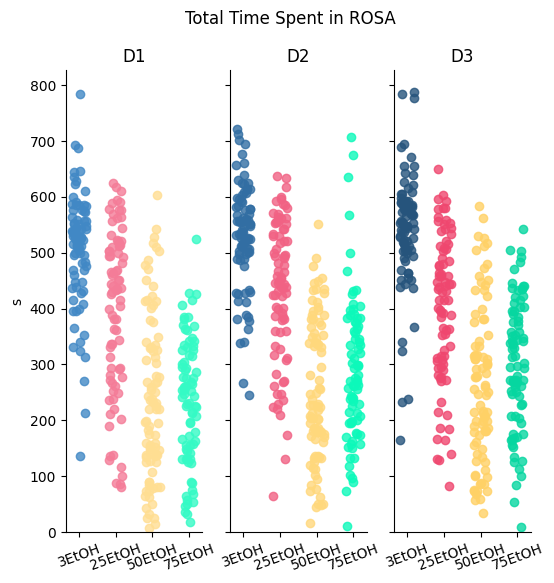

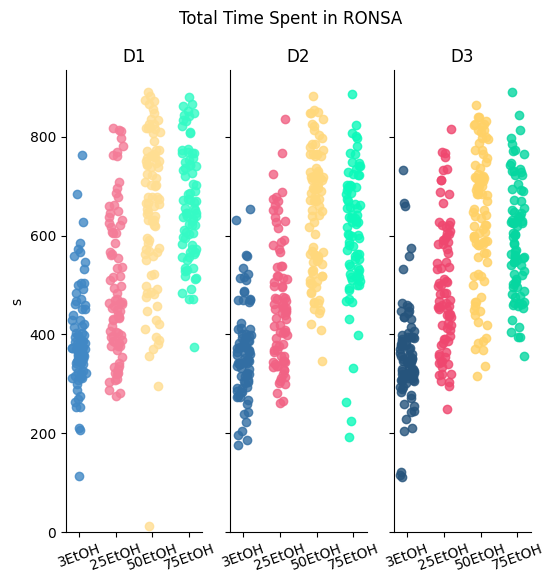

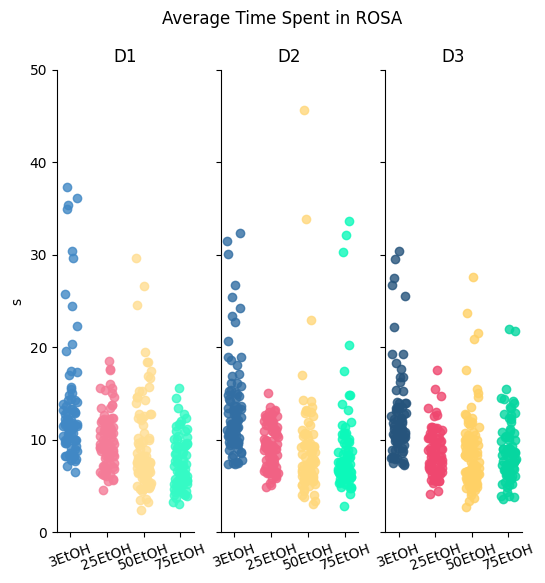

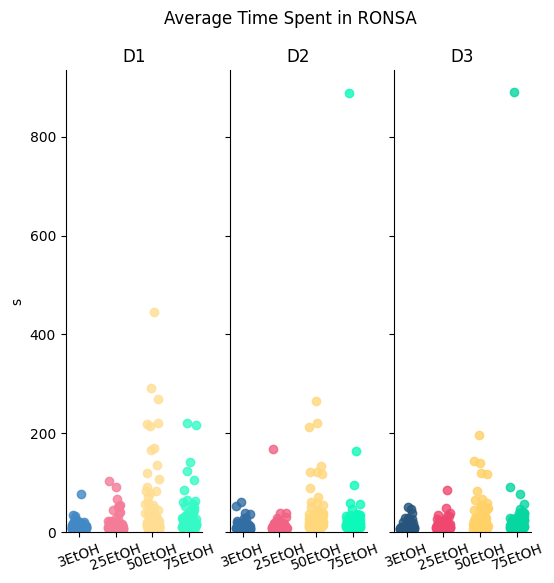

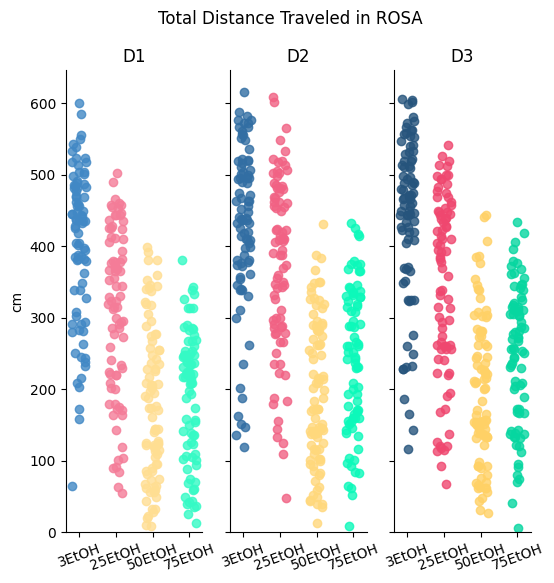

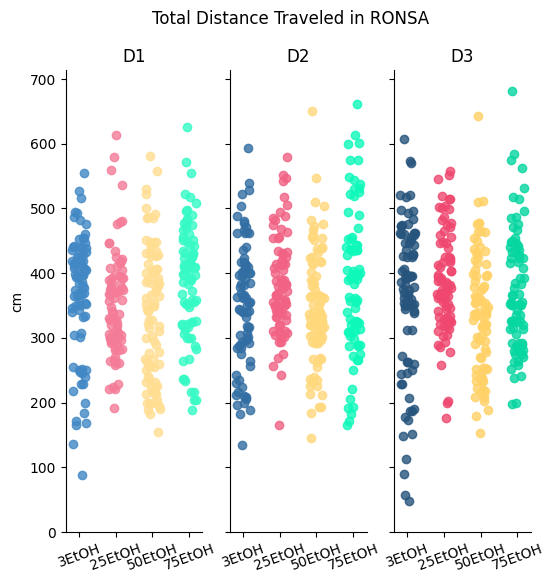

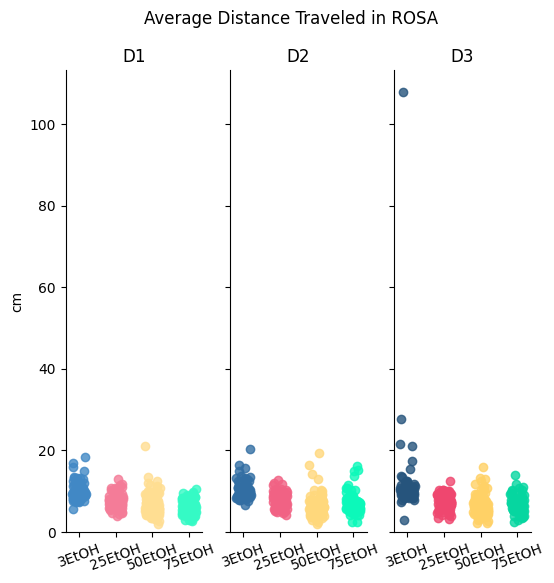

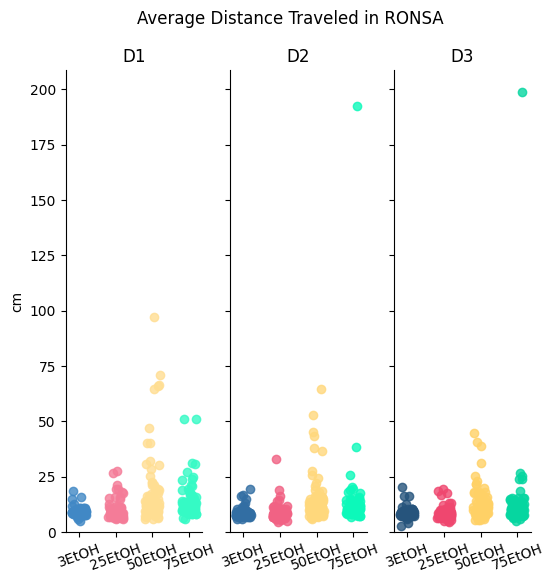

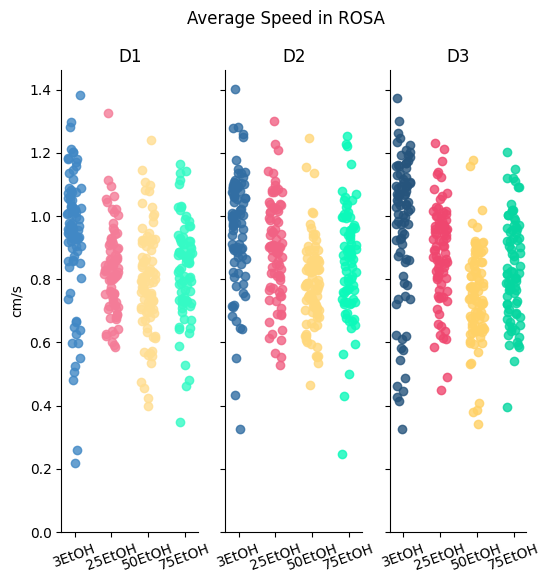

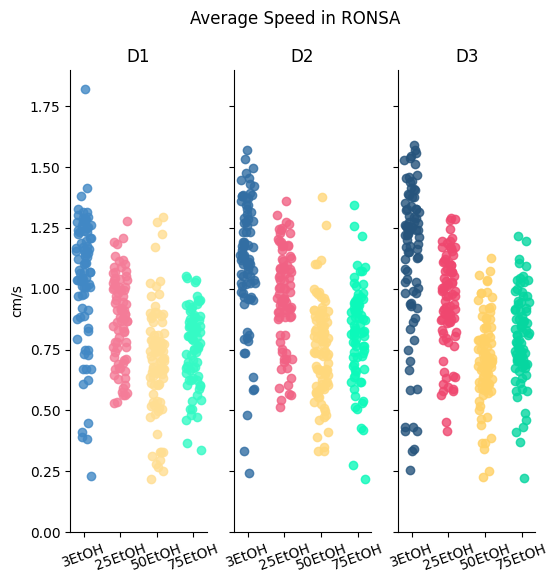

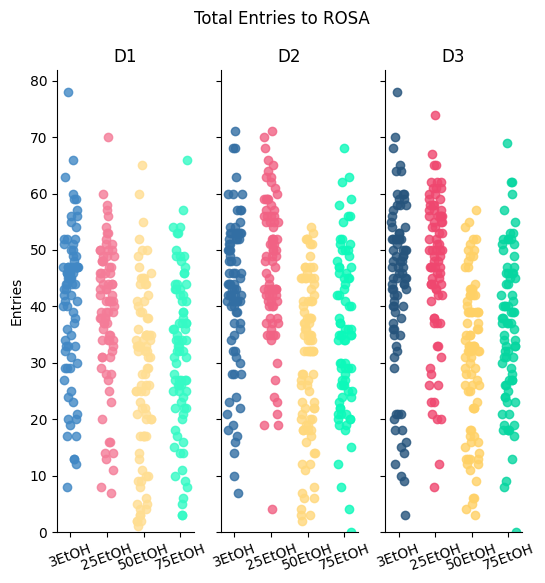

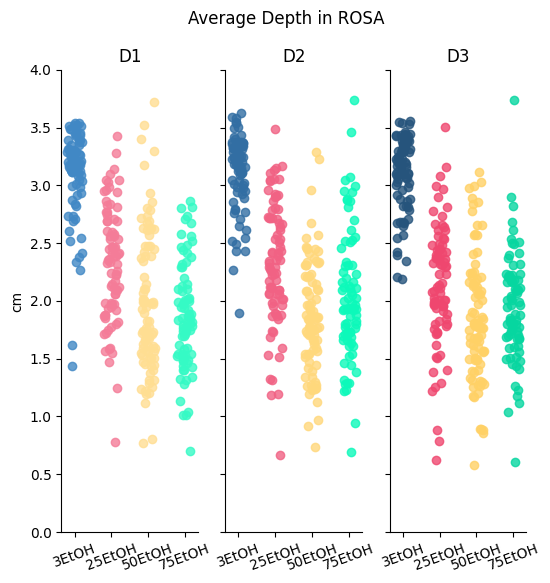

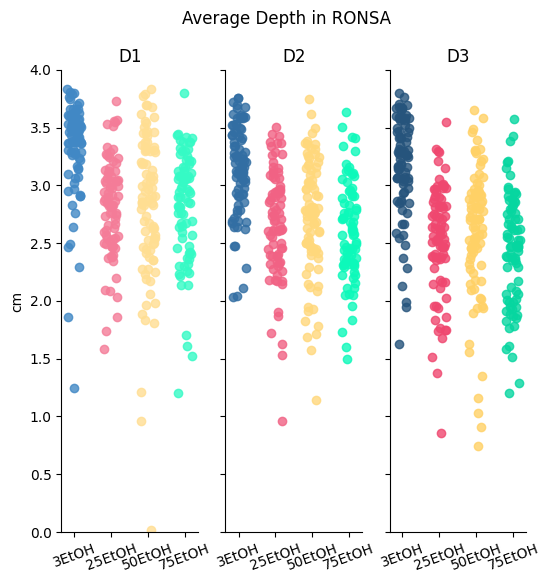

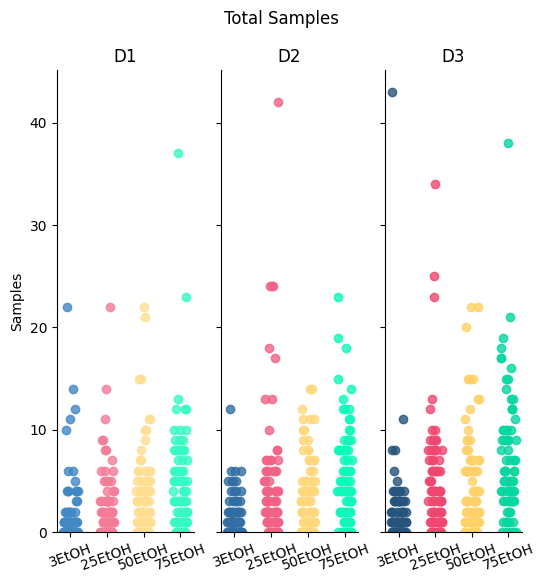

In [4]:
# time
# total time spent in rosa/ronsa
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='duration', agg_func='sum',
                 colors=colors, ylab='s', plot_title='Total Time Spent in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='duration', agg_func='sum',
                 colors=colors, ylab='s', plot_title='Total Time Spent in RONSA')

# average time spent in rosa/ronsa, i also specify ylim_top in the rosa case \
# if you need to change the max value of the y-axis
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='duration', agg_func='mean', ylim_top=50,
                 colors=colors, ylab='s', plot_title='Average Time Spent in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='duration', agg_func='mean',
                 colors=colors, ylab='s', plot_title='Average Time Spent in RONSA')

# distance
# total distance traveled in rosa/ronsa
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='distance', agg_func='sum',
                 colors=colors, ylab='cm', plot_title='Total Distance Traveled in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='distance', agg_func='sum',
                 colors=colors, ylab='cm', plot_title='Total Distance Traveled in RONSA')

# average distance traveled in rosa/ronsa
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='distance', agg_func='mean',
                 colors=colors, ylab='cm', plot_title='Average Distance Traveled in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='distance', agg_func='mean',
                 colors=colors, ylab='cm', plot_title='Average Distance Traveled in RONSA')

# average speed across bouts
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='speed', agg_func='mean',
                 colors=colors, ylab='cm/s', plot_title='Average Speed in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='speed', agg_func='mean',
                 colors=colors, ylab='cm/s', plot_title='Average Speed in RONSA')

# total entries to rosa
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='entry', agg_func='sum',
                 colors=colors, ylab='Entries', plot_title='Total Entries to ROSA')

# TO-DO latency to reenter rosa = avg time spent in ronsa so need to ask

# average max depth in rosa/ronsa, set ylim_top=4 for alignment with openbarr
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='max depth', agg_func='mean', ylim_top=4,
                 colors=colors, ylab='cm', plot_title='Average Depth in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='max depth', agg_func='mean', ylim_top=4,
                 colors=colors, ylab='cm', plot_title='Average Depth in RONSA')

# samples
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='sample', agg_func='sum',
                 colors=colors, ylab='Samples', plot_title='Total Samples')

## Behavior Across Time Plots

In [8]:
test = tracking_df[(tracking_df['condition'] == '3EtOH') & (tracking_df['day'] == 'D1') & (tracking_df['id'] == 'JH-20-15ME3_D1.txt')].copy()

In [23]:
bin_size, total_time = 60, 900
test['bins'] = pd.cut(test['time'], bin_size*np.arange(total_time/bin_size+1))

# TODO total/average time

# TODO velocity

# TODO total/average distance moved

# TODO average depth